<h1>QUESTION SUBJECT DETECTION</h1>
The model in this project can read and detect a sentence that has been input. This model will determine which sentence is part of what subject. This model will be useful for use by librarians in sorting books based on just a piece of content. Or useful for other people related to education.

<h2> ABOUT DATASET </h5>
<h5>IITJEE NEET AIIMS Students Questions Data</h5>
Subject classification from Questions

* https://www.kaggle.com/datasets/mrutyunjaybiswal/iitjee-neet-aims-students-questions-data

In India, every year lacs of students sit for competitive examinations like JEE Advanced, JEE Mains, NEET, etc. These exams are said to be the gateway to get admission into India's premier Institutes such as IITs, NITs, AIIMS, etc. Keeping in mind that the competition is tough as lacs of students appear for these examinations, there has been an enormous development in Ed Tech Industry in India, fortuning the dreams of lacs of aspirants via providing online as well as offline coaching, mentoring, etc. This particular dataset consists of questions/doubts raised by students preparing for such examinations.

Content
The dataset contains Students-questions.csv file in version 1 as of now.
Inside the CSV file, we have two columns:

* eng: The full question or description of the questions
* Subject: Which subject does the question belong to. It has 4 classes, Physics, Chemistry, Biology, and Mathematics.


<h1> WHAT ARE YOU WAITING FOR? LET'S GO!!

Donwload Dataset from Kaggle

In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"srikresna","key":"c90f9c19af6b129911ae9410dd23cde4"}'}

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d mrutyunjaybiswal/iitjee-neet-aims-students-questions-data

 52% 5.00M/9.60M [00:00<00:00, 42.7MB/s]
100% 9.60M/9.60M [00:00<00:00, 69.6MB/s]


In [5]:
!unzip iitjee-neet-aims-students-questions-data.zip

Archive:  iitjee-neet-aims-students-questions-data.zip
  inflating: subjects-questions.csv  


Import Library

In [58]:
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
stopwords.words('english')
import string
string.punctuation
from nltk.stem.porter import PorterStemmer

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


Understanding Dataset

In [7]:
df = pd.read_csv('subjects-questions.csv')
df

,eng,Subject
0,An anti-forest measure is\nA. Afforestation\nB...,Biology
1,"Among the following organic acids, the acid pr...",Chemistry
2,If the area of two similar triangles are equal...,Maths
3,"In recent year, there has been a growing\nconc...",Biology
4,Which of the following statement\nregarding tr...,Physics
...,...,...
122514,Which of the following group of\ncharacters is...,Biology
122515,Light year is the\nA. light emitted by the sun...,Physics
122516,Member of Dipnoi are native of\nA. India.\nB. ...,Biology
122517,"In one average-life,\nA. half the active nucle...",Physics


In [11]:
df.Subject.unique()

array(['Biology', 'Chemistry', 'Maths', 'Physics'], dtype=object)

In [12]:
df.isna().sum()

eng        0
Subject    0
dtype: int64

Exploratory Data Analysis (EDA)

In [17]:
df.head()

,eng,Subject
0,An anti-forest measure is\nA. Afforestation\nB...,Biology
1,"Among the following organic acids, the acid pr...",Chemistry
2,If the area of two similar triangles are equal...,Maths
3,"In recent year, there has been a growing\nconc...",Biology
4,Which of the following statement\nregarding tr...,Physics


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



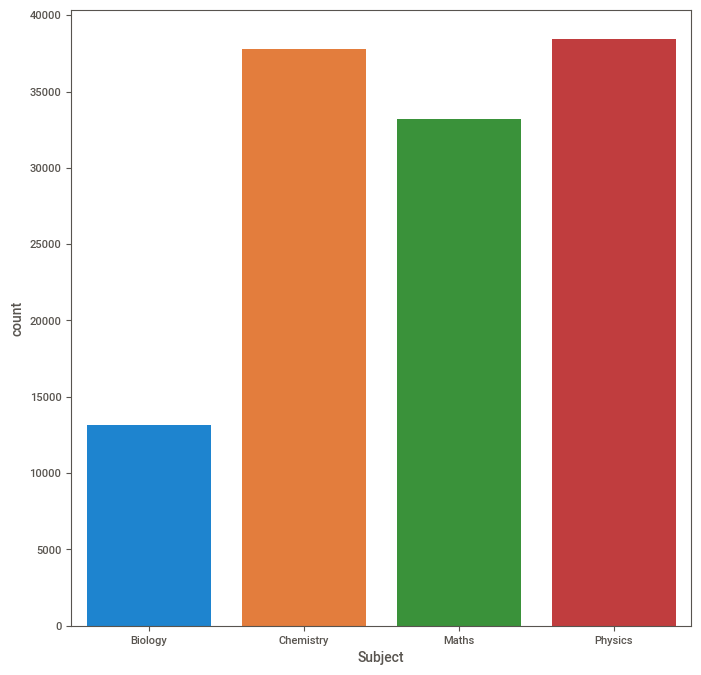

In [46]:
plt.figure(figsize = (8, 8))
sns.countplot(df['Subject'])

From the countplot above, biology have a less example then another

Data Pre-Processing

because this dataset is categorical, we need doing one-hot encoding first

In [52]:
category = pd.get_dummies(df.Subject)
df_new = pd.concat([df, category], axis = 1)
df_new = df_new.drop(columns = 'Subject')

df_new

,eng,Biology,Chemistry,Maths,Physics
0,An anti-forest measure is\nA. Afforestation\nB...,1,0,0,0
1,"Among the following organic acids, the acid pr...",0,1,0,0
2,If the area of two similar triangles are equal...,0,0,1,0
3,"In recent year, there has been a growing\nconc...",1,0,0,0
4,Which of the following statement\nregarding tr...,0,0,0,1
...,...,...,...,...,...
122514,Which of the following group of\ncharacters is...,1,0,0,0
122515,Light year is the\nA. light emitted by the sun...,0,0,0,1
122516,Member of Dipnoi are native of\nA. India.\nB. ...,1,0,0,0
122517,"In one average-life,\nA. half the active nucle...",0,0,0,1


Text Processing

Make functions for removal of stopwords, lemmatizing and cleaning text:

In [81]:
def remove_Stopwords(text ):
    stop_words = set(stopwords.words('english')) 
    words = word_tokenize( text.lower() ) 
    sentence = [w for w in words if not w in stop_words]
    return " ".join(sentence)
    

def lemmatize_text(text):
    wordlist=[]
    lemmatizer = WordNetLemmatizer() 
    sentences=sent_tokenize(text)
    for sentence in sentences:
        words=word_tokenize(sentence)
        for word in words:
            wordlist.append(lemmatizer.lemmatize(word))
    return ' '.join(wordlist) 

def clean_text(text ): 
    delete_dict = {sp_character: '' for sp_character in string.punctuation} 
    delete_dict[' '] = ' ' 
    table = str.maketrans(delete_dict)
    text1 = text.translate(table)
    textArr= text1.split()
    text2 = ' '.join([w for w in textArr]) 
    
    return text2.lower()

def stemSentence(text):
    porter = PorterStemmer()
    token_words=word_tokenize(text)
    token_words
    stem_sentence=[]
    for word in token_words:
        stem_sentence.append(porter.stem(word))
        stem_sentence.append(" ")
    return "".join(stem_sentence)

In [59]:
df_new['new_eng'] = df_new['eng'].apply(remove_Stopwords)
df_new['new_eng'] = df_new['eng'].apply(lemmatize_text)
df_new['new_eng'] = df_new['eng'].apply(clean_text)
df_new

,eng,Biology,Chemistry,Maths,Physics,new_eng
0,An anti-forest measure is\nA. Afforestation\nB...,1,0,0,0,an antiforest measure is a afforestation b sel...
1,"Among the following organic acids, the acid pr...",0,1,0,0,among the following organic acids the acid pre...
2,If the area of two similar triangles are equal...,0,0,1,0,if the area of two similar triangles are equal...
3,"In recent year, there has been a growing\nconc...",1,0,0,0,in recent year there has been a growing concer...
4,Which of the following statement\nregarding tr...,0,0,0,1,which of the following statement regarding tra...
...,...,...,...,...,...,...
122514,Which of the following group of\ncharacters is...,1,0,0,0,which of the following group of characters is ...
122515,Light year is the\nA. light emitted by the sun...,0,0,0,1,light year is the a light emitted by the sun i...
122516,Member of Dipnoi are native of\nA. India.\nB. ...,1,0,0,0,member of dipnoi are native of a india b afric...
122517,"In one average-life,\nA. half the active nucle...",0,0,0,1,in one averagelife a half the active nuclei de...


In [82]:
df_new['stem_eng'] = df_new['new_eng'].apply(stemSentence)

In [83]:
df_new

,eng,Biology,Chemistry,Maths,Physics,new_eng,stem_eng
0,An anti-forest measure is\nA. Afforestation\nB...,1,0,0,0,an antiforest measure is a afforestation b sel...,an antiforest measur is a afforest b select gr...
1,"Among the following organic acids, the acid pr...",0,1,0,0,among the following organic acids the acid pre...,among the follow organ acid the acid present i...
2,If the area of two similar triangles are equal...,0,0,1,0,if the area of two similar triangles are equal...,if the area of two similar triangl are equal t...
3,"In recent year, there has been a growing\nconc...",1,0,0,0,in recent year there has been a growing concer...,in recent year there ha been a grow concern ab...
4,Which of the following statement\nregarding tr...,0,0,0,1,which of the following statement regarding tra...,which of the follow statement regard transform...
...,...,...,...,...,...,...,...
122514,Which of the following group of\ncharacters is...,1,0,0,0,which of the following group of characters is ...,which of the follow group of charact is presen...
122515,Light year is the\nA. light emitted by the sun...,0,0,0,1,light year is the a light emitted by the sun i...,light year is the a light emit by the sun in o...
122516,Member of Dipnoi are native of\nA. India.\nB. ...,1,0,0,0,member of dipnoi are native of a india b afric...,member of dipnoi are nativ of a india b africa...
122517,"In one average-life,\nA. half the active nucle...",0,0,0,1,in one averagelife a half the active nuclei de...,in one averagelif a half the activ nuclei deca...


Model Building

In [85]:
length = df_new['stem_eng'].str.len().max()
df_new.columns

Index(['eng', 'Biology', 'Chemistry', 'Maths', 'Physics', 'new_eng',
       'stem_eng'],
      dtype='object')

Change into numpy array

In [87]:
news = df_new['stem_eng'].values
label = df_new[['Biology', 'Chemistry', 'Maths', 'Physics']].values
label, news

(array([[1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 0],
        ...,
        [1, 0, 0, 0],
        [0, 0, 0, 1],
        [0, 0, 0, 1]], dtype=uint8),
 array(['an antiforest measur is a afforest b select graze c clear forest d select fell ',
        'among the follow organ acid the acid present in rancid butter is a pyruv acid b lactic acid c butyr acid d acet acid ',
        'if the area of two similar triangl are equal then they are a equilater b isoscel c congruent d not congruent ',
        ...,
        'member of dipnoi are nativ of a india b africa and australia c new zealand d none of the abov ',
        'in one averagelif a half the activ nuclei decay b less than half the activ nuclei decay c more than half the activ nuclei decay d all the nuclei decay ',
        'state whether true or fals a magnet field is a region around a magnet where magnet line of forc act a true b fals '],
       dtype=object))

Divided into training and test

In [88]:
news_train, news_test, label_train, label_test = train_test_split(news, label, test_size = 0.2, random_state = 123)

In [ ]:


#tokenisasi
tokenizer = Tokenizer(num_words = length, oov_token = '', filters='!"#$%&()*+,-./:;<=>@[\]^_`{|}~ ')
tokenizer.fit_on_texts(news_train)
tokenizer.fit_on_texts(news_test)

sequences_train = tokenizer.texts_to_sequences(news_train)
sequences_test = tokenizer.texts_to_sequences(news_test)

padded_train = pad_sequences(sequences_train)
padded_test = pad_sequences(sequences_test)


In [ ]:


#bangun model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=5000, output_dim=16),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])

In [ ]:
#compile

model.compile(loss ='categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

In [ ]:
#cek model

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 16)          80000     
                                                                 
 lstm_2 (LSTM)               (None, 64)                20736     
                                                                 
 dense_4 (Dense)             (None, 128)               8320      
                                                                 
 dense_5 (Dense)             (None, 4)                 516       
                                                                 
Total params: 109,572
Trainable params: 109,572
Non-trainable params: 0
_________________________________________________________________


In [ ]:


#Callback Function
class accCallback(Callback):
   def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') >= 0.90 and logs.get('val_accuracy') >= 0.90):
            print("\nAccuracy and Val_Accuracy has reached 90%!", "\nEpoch: ", epoch)
            self.model.stop_training = True

callbacks = accCallback()

auto_reduction_LR = ReduceLROnPlateau(
    monitor = 'val_accuracy',
    patience = 2, #setelah 2 epoch, jika tidak ada kenaikan maka LR berkurang
    verbose = 1,
    factor = 0.2,
    min_lr = 0.000003
)

auto_stop_learn = EarlyStopping(
    monitor = 'val_accuracy',
    min_delta = 0,
    patience = 4,
    verbose = 1,
    mode = 'auto' 
)

#latih model
history = model.fit(padded_train, label_train,
                    steps_per_epoch = 30,
                    epochs = 100,
                    validation_data = (padded_test, label_test),
                    verbose = 1,
                    validation_steps = 50,
                    callbacks=[callbacks, auto_reduction_LR, auto_stop_learn], 
                    )

Epoch 1/100
30/30 [==============================] - 15s 429ms/step - loss: 1.3070 - accuracy: 0.3515 - val_loss: 1.8798 - val_accuracy: 0.2680 - lr: 0.0010
Epoch 2/100
30/30 [==============================] - 13s 438ms/step - loss: 1.1204 - accuracy: 0.5155 - val_loss: 0.9211 - val_accuracy: 0.5968 - lr: 0.0010
Epoch 3/100
30/30 [==============================] - 13s 431ms/step - loss: 0.9063 - accuracy: 0.6064 - val_loss: 0.7551 - val_accuracy: 0.6853 - lr: 0.0010
Epoch 4/100
30/30 [==============================] - 12s 414ms/step - loss: 0.7238 - accuracy: 0.7031 - val_loss: 0.6294 - val_accuracy: 0.7578 - lr: 0.0010
Epoch 5/100
30/30 [==============================] - 12s 413ms/step - loss: 0.5615 - accuracy: 0.7945 - val_loss: 0.5951 - val_accuracy: 0.7592 - lr: 0.0010
Epoch 6/100
30/30 [==============================] - 12s 410ms/step - loss: 0.4782 - accuracy: 0.8287 - val_loss: 0.4202 - val_accuracy: 0.8566 - lr: 0.0010
Epoch 7/100
30/30 [==============================] - 12s 4

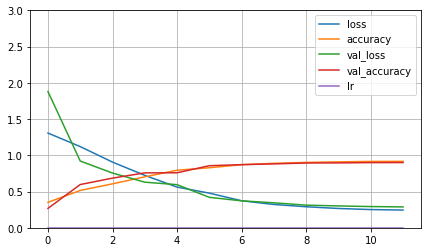

In [ ]:
#plotting

pd.DataFrame(history.history).plot(figsize=(7, 4))
plt.grid(True)
plt.gca().set_ylim(0,3) #sumbu y

plt.show()